# Jolideco Analysis of Chandra Data of E0102

In [3]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib as mpl
from astropy.visualization import simple_norm
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.wcs import FITSFixedWarning
from jolideco.core import MAPDeconvolver
from jolideco.models import (
    SpatialFluxComponent,
    FluxComponents,
    NPredModels,
    NPredCalibration,
    NPredCalibrations
)
from jolideco.priors import GMMPatchPrior, GaussianMixtureModel
from jolideco.utils.norms import IdentityImageNorm, FixedMaxImageNorm
from itertools import zip_longest
from regions import CircleSkyRegion
from gammapy.maps import Maps, WcsGeom, Map

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FITSFixedWarning)

In [5]:
# for vscode dark theme
plt.style.use('dark_background')
mpl.rcParams['figure.facecolor'] = '#25292E'


In [6]:
if "snakemake" in globals():
    filenames = [Path(_) for _ in snakemake.input]
    filename_jolideco_result = Path(snakemake.output.filename_jolideco_result)
    filename_npred_stacked = Path(snakemake.output.filename_npred_stacked)
else:
    config_name = "vela-junior-above-10GeV-data"
    PATH_BASE = Path(f"../../results/{config_name}/")
    filenames = (PATH_BASE / "input").glob("*.fits")
    filename_jolideco_result = PATH_BASE / f"{config_name}-result-jolideco.fits"
    filename_npred_stacked = PATH_BASE / f"{config_name}-npred.fits"

In [7]:
filenames = list(Path("../../results/e0102-broadband/").glob("*/maps/*-counts.fits"))

In [8]:
datasets = {}

def read_dataset(filename_counts):
    """Read counts, exposure and psf maps."""
    filename_exposure = filename_counts.parent / filename_counts.name.replace("counts", "exposure")
    filename_psf = filename_counts.parent / filename_counts.name.replace("counts", "e0102-marx-psf")
    counts = Map.read(filename_counts)    

    psf = Map.read(filename_psf)
    return {
        "counts": counts,
        "exposure": Map.read(filename_exposure),
        "psf": psf.cutout(psf.geom.center_skydir, width="10 arcsec"),
        "background": Map.from_geom(counts.geom) + 1e-2,
    }



for filename in filenames:
    obs_id = filename.parts[-3]
    datasets[f"obs-id-{obs_id}"] = read_dataset(filename)


## Counts

In [9]:
stacked = Map.from_geom(datasets["obs-id-1308"]["counts"].geom)

for name, dataset in datasets.items():
    stacked += dataset["counts"]

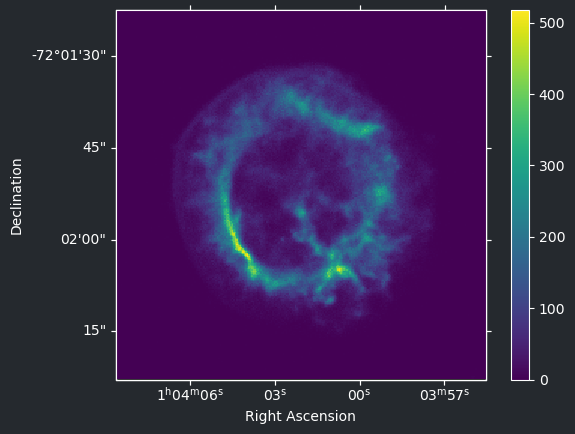

In [10]:
stacked.plot(cmap="viridis", add_cbar=True);

## PSF

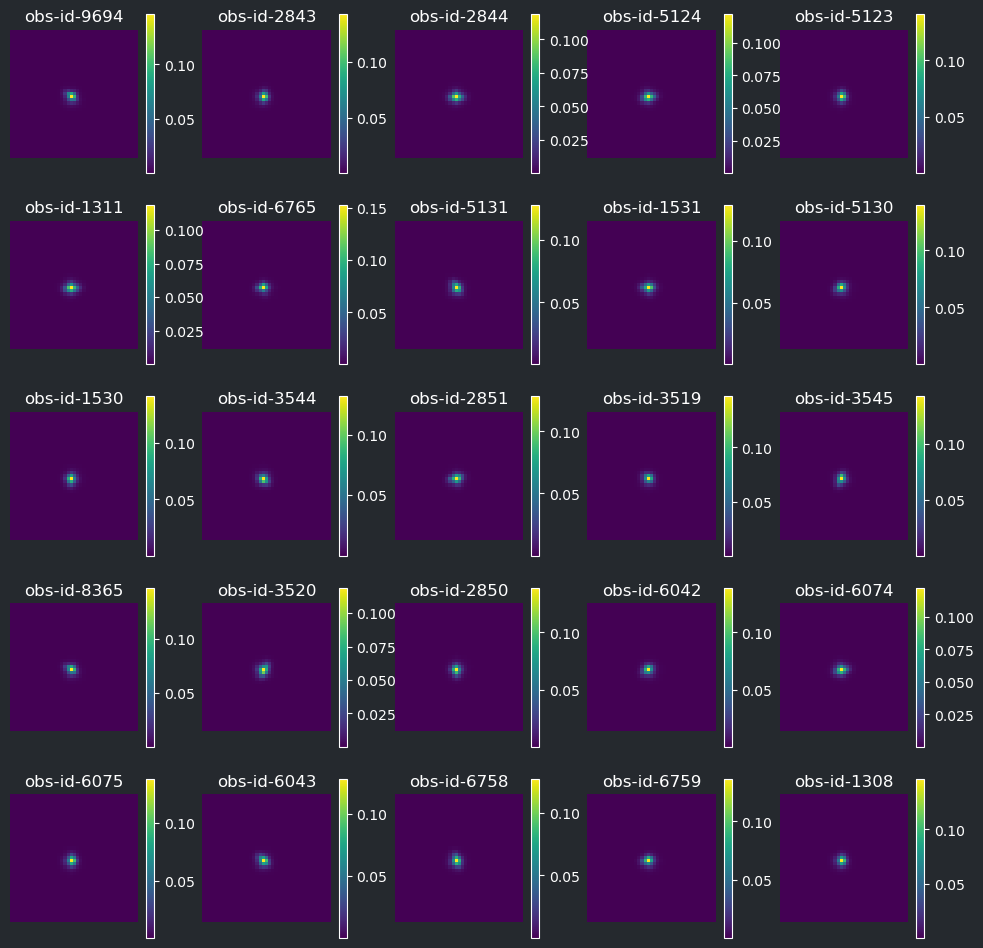

In [11]:
wcs = datasets["obs-id-1308"]["psf"].geom.wcs

fig, axes = plt.subplots(
    ncols=5,
    nrows=5,
    subplot_kw={"projection": wcs},
    figsize=(12, 12)
)

for ax, (name, dataset) in zip(axes.flat, datasets.items()):
    psf = dataset["psf"]
    psf.plot(ax=ax, cmap="viridis", add_cbar=True, stretch="linear")
    ax.set_title(f"{name}")
    ax.axis("off")

In [27]:
def to_jolideco_dataset(maps, dtype=np.float32):
    """Convert Gammapy maps to Jolideco dataset."""
    return {
        "counts": maps["counts"].data.astype(dtype),
        "background": maps["background"].data.astype(dtype),
        "psf": {"e0102": maps["psf"].data.astype(dtype)},
        "exposure": maps["exposure"].data.astype(dtype),
    }

In [28]:
datasets_jolideco = {name: to_jolideco_dataset(maps) for name, maps in datasets.items()}

## Run Jolideco

In [99]:
gmm = GaussianMixtureModel.from_registry("chandra-snrs-v0.1")
gmm.stride = 4
print(gmm)

GaussianMixtureModel
--------------------

  type                  : chandra-snrs-v0.1



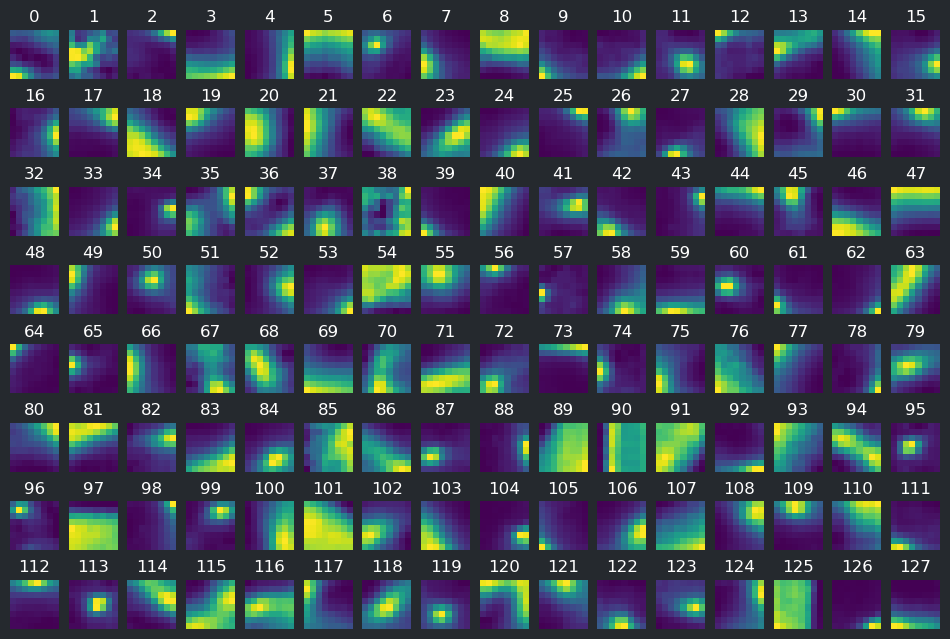

In [100]:
gmm.plot_mean_images(ncols=16, figsize=(12, 8))

In [111]:
patch_prior = GMMPatchPrior(
    gmm=gmm,
    cycle_spin=False,
    cycle_spin_subpix=True,
    stride=4,
    norm=IdentityImageNorm()
)


shape = datasets_jolideco["obs-id-1308"]["counts"].shape
flux_init = np.random.normal(loc=3, scale=0.01, size=shape).astype(np.float32)

component = SpatialFluxComponent.from_numpy(
    flux=flux_init,
    prior=patch_prior,
    use_log_flux=True,
    upsampling_factor=2,
)


components = FluxComponents()
components["e0102"] = component

print(components)

FluxComponents
--------------

  e0102                 : 

    use_log_flux        : True
    upsampling_factor   : 2
    frozen              : False
    prior               : 

      type              : gmm-patches
      stride            : 4
      cycle_spin        : False
      cycle_spin_subpix : True
      jitter            : False
      gmm               : 

        type            : chandra-snrs-v0.1

      norm              : 

        type            : identity

      patch_norm        : 

        type            : std-subtract-mean

      device            : cpu





In [112]:
calibrations = NPredCalibrations()

for name in datasets_jolideco:
    calibration = NPredCalibration(background_norm=1., frozen=False)
    calibrations[name] = calibration


calibrations["obs-id-1308"].shift_xy.requires_grad = False

print(calibrations)

NPredCalibrations
-----------------

  obs-id-9694           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-2843           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-2844           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-5124           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-5123           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-1311           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-6765        

In [113]:
deconvolve = MAPDeconvolver(n_epochs=50, learning_rate=0.1, beta=1)
print(deconvolve)

MAPDeconvolver
--------------

  n_epochs              : 50
  beta                  : 100
  learning_rate         : 0.100
  compute_error         : False
  stop_early            : False
  stop_early_n_average  : 10
  device                : cpu



In [114]:
#datasets_train_id = np.random.choice(datasets_jolideco.values(), size=20, replace=False)

In [118]:
result = deconvolve.run(
    datasets=datasets_jolideco,
    components=components,
    calibrations=calibrations
)

  0%|          | 0/50 [00:00<?, ?it/s]

/Users/adonath/software/mambaforge/envs/jolideco-fermi-examples/lib/python3.9/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/adonath/software/mambaforge/envs/jolideco-fermi-examples/lib/python3.9/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(0.5, 2)

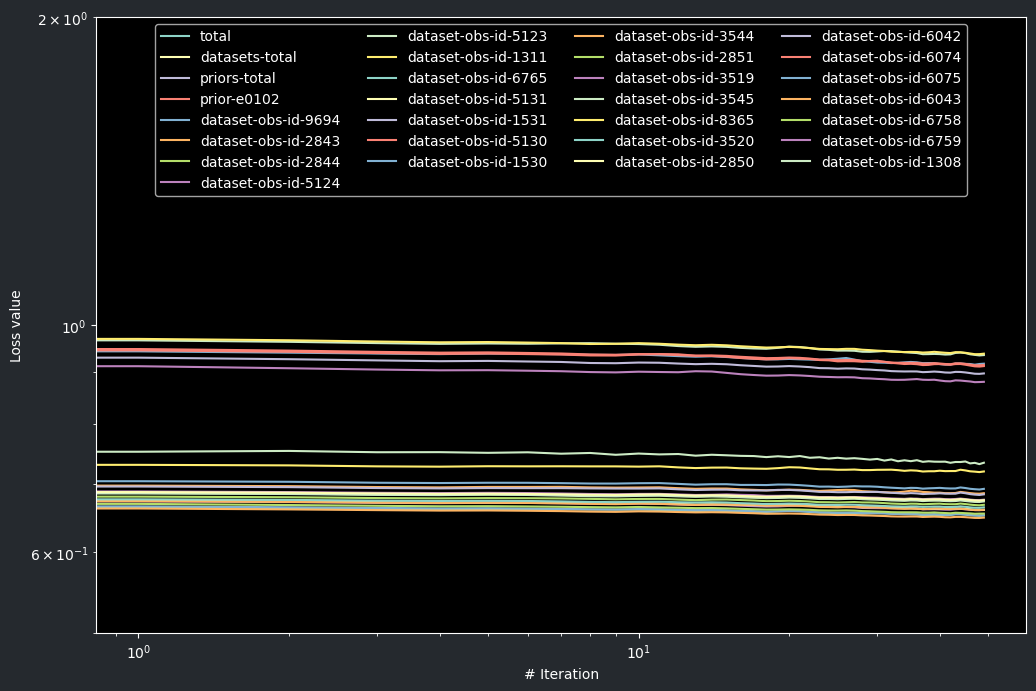

In [119]:
plt.figure(figsize=(12, 8))
result.plot_trace_loss()
plt.legend(loc="upper center", ncols=4)
plt.ylim(0.5, 2)

## Results

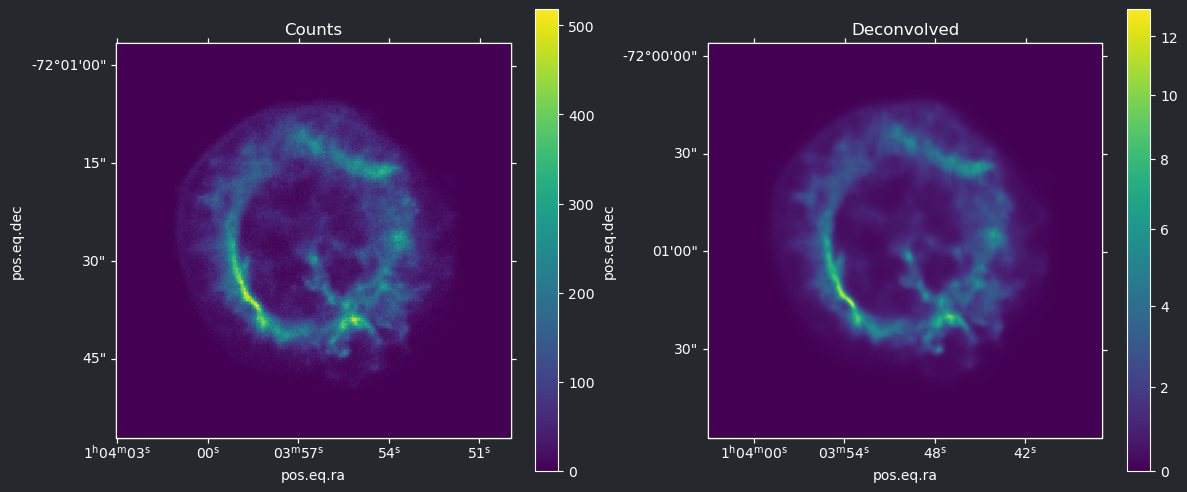

In [121]:
counts = np.sum([_["counts"] for _ in datasets_jolideco.values()], axis=0)

fig, axes = plt.subplots(
    ncols=2,
    subplot_kw={"projection": wcs},
    figsize=(14, 6)
)

norm_asinh = simple_norm(
    counts,
    min_cut=0,
    max_cut=13,
    stretch="asinh",
    asinh_a=0.8
)



im = axes[0].imshow(counts, origin="lower", interpolation="None")
axes[0].set_title("Counts")
plt.colorbar(im);

im = axes[1].imshow(result.components.flux_upsampled_total_numpy, origin="lower", norm=norm_asinh, interpolation="gaussian")
axes[1].set_title("Deconvolved");
plt.colorbar(im);
plt.savefig("/Users/adonath/Desktop/deconvolved.png", dpi=300)


In [73]:
print(calibrations)

NPredCalibrations
-----------------

  obs-id-9694           : 

    shift_x             : 0.015
    shift_y             : 0.098
    background_norm     : 0.964
    frozen              : False

  obs-id-2843           : 

    shift_x             : 0.077
    shift_y             : 0.567
    background_norm     : 0.281
    frozen              : False

  obs-id-2844           : 

    shift_x             : 0.461
    shift_y             : 0.797
    background_norm     : 0.124
    frozen              : False

  obs-id-5124           : 

    shift_x             : 0.383
    shift_y             : 0.335
    background_norm     : 0.022
    frozen              : False

  obs-id-5123           : 

    shift_x             : 0.456
    shift_y             : 0.601
    background_norm     : 0.556
    frozen              : False

  obs-id-1311           : 

    shift_x             : -0.091
    shift_y             : 0.147
    background_norm     : 0.990
    frozen              : False

  obs-id-6765       

In [ ]:
# could visually compare aginst https://arxiv.org/abs/2303.12686
geom = datasets["vela-junior-above-10GeV-data-psf0"]["counts"].geom.to_image()
flux = Map.from_geom(geom, data=component.flux_numpy)

geom_icrc = WcsGeom.create(
    skydir=geom.center_skydir,
    width=3 * u.deg,
    binsz=0.02
)

flux_icrs = flux.interp_to_geom(geom_icrc)

norm_pwr = simple_norm(
    flux.data,
    min_cut=0,
    max_cut=0.6,
    stretch="power",
    power=1.3,
)
flux_icrs.plot(cmap="cubehelix", norm=norm_pwr)

In [ ]:
result.write(filename_jolideco_result, overwrite=True)

## Residuals

In [ ]:
npreds = {}

for name, dataset in datasets_jolideco.items():
    model = NPredModels.from_dataset_numpy(
        dataset=dataset,
        components=result.components,
    )
    
    fluxes = result.components.to_flux_tuple()
    npred = model.evaluate(fluxes=fluxes).detach().numpy()[0, 0]
    npreds[name] =  Map.from_geom(data=npred, geom=geom)
    

npreds_calibrated = {}

for name, dataset in datasets_jolideco.items():
    model = NPredModels.from_dataset_numpy(
        dataset=dataset,
        components=result.components,
        calibration=calibrations[name]
    )
    
    fluxes = result.components.to_flux_tuple()
    npred = model.evaluate(fluxes=fluxes).detach().numpy()[0, 0]
    npreds_calibrated[name] = Map.from_geom(data=npred, geom=geom)
    

In [ ]:
npred_stacked = Map.from_geom(geom=geom)

for npred in npreds_calibrated.values():
    npred_stacked.stack(npred)


npred_stacked.write(filename_npred_stacked, overwrite=True)

In [ ]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    subplot_kw={"projection": wcs},
    gridspec_kw={"wspace": 0.2},
    figsize=(12, 12)
)


for name, ax in zip_longest(datasets_jolideco, axes.flat):
    if name is None:
        ax.set_visible(False)
        continue
        
    dataset = datasets[name]
    counts = dataset["counts"].sum_over_axes(keepdims=False).smooth(5)
    npred = npreds[name].smooth(5)
    
    residual = (counts - npred) / np.sqrt(npred)
    
    residual.plot(ax=ax, vmin=-0.5, vmax=0.5, cmap="RdBu", add_cbar=True)
    ax.set_title(f"{name}")

In [ ]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    subplot_kw={"projection": wcs},
    gridspec_kw={"wspace": 0.2},
    figsize=(12, 12)
)


for name, ax in zip_longest(datasets_jolideco, axes.flat):
    if name is None:
        ax.set_visible(False)
        continue
        
    dataset = datasets[name]
    counts = dataset["counts"].sum_over_axes(keepdims=False).smooth(5)
    npred = npreds_calibrated[name].smooth(5)
    
    residual = (counts - npred) / np.sqrt(npred)
    
    residual.plot(ax=ax, vmin=-0.5, vmax=0.5, cmap="RdBu", add_cbar=True)
    ax.set_title(f"{name}")